# **Airfare Price Prediction**

Dennis Myasnyankin, Vannessa Salazar, and Christine Vu

Shiley-Marcos School of Engineering, University of San Diego

ADS 599: Capstone Project

Professor Ebrahim Tarshizi

December 11, 2023

***

## **Data Importing**

### **Import Libraries**

In [23]:
import pandas as pd
from pandas import json_normalize
from datetime import datetime
import zipfile
import io
import os
import json
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import seaborn as sns


### **Data Acquisition and Aggregation**

In [3]:
github_repo_url = 'https://github.com/VSbr22/Capstone/raw/main/data/jsons.zip'

# Fetch the zip file from the GitHub repository
response = requests.get(github_repo_url)
zip_file = BytesIO(response.content)

In [4]:
# Unzip the folder
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('your_unzipped_folder')

In [7]:
# List all JSON files in the 'jsons' subfolder
json_subfolder = os.path.join('your_unzipped_folder', 'jsons')
json_files = [file for file in os.listdir(json_subfolder) if file.endswith('.json')]

# Initialize an empty list for extracted data
out = []

# Iterate over each JSON file
for file_name in json_files:
    # Load JSON data
    with open(os.path.join(json_subfolder, file_name), 'r') as file:
        data = json.load(file)

    # Christines code for processing
    schedule_descs = data["groupedItineraryResponse"]["scheduleDescs"]
    leg_descs = data["groupedItineraryResponse"]["legDescs"]
    itinerary_groups = data["groupedItineraryResponse"]["itineraryGroups"]

    # Iterate over itinerary groups
    for group in itinerary_groups:
        itineraries = group.get("itineraries", [])
        departure_date = group["groupDescription"]["legDescriptions"][0]["departureDate"]
        departure_city = group["groupDescription"]["legDescriptions"][0]["departureLocation"]
        arrival_date = group["groupDescription"]["legDescriptions"][0].get("arrivalDate", departure_date)
        arrival_location = group["groupDescription"]["legDescriptions"][0]["arrivalLocation"]

        # Calculate "Days Until Departure" based on current date and departure date
        current_date = datetime.now()
        departure_date = datetime.strptime(departure_date, "%Y-%m-%d")
        days_until_departure = (departure_date - current_date).days

        # Iterate over itineraries in the group
        for itinerary in itineraries:
            legs = itinerary.get("legs", [])
            for leg in legs:
                schedules = leg_descs[leg.get('ref') - 1].get("schedules", [])
                for schedule in schedules:
                    schedule_data = schedule_descs[schedule.get('ref') - 1]

                    departure_time = schedule_data["departure"]["time"].split("+")[0]
                    arrival_time = schedule_data["arrival"]["time"].split("+")[0]
                    flight_duration = schedule_data["elapsedTime"]
                    operating_carrier = schedule_data["carrier"]["operating"]
                    aircraft_type = schedule_data["carrier"]["equipment"]["code"]
                    cabin_class = itinerary["pricingInformation"][0]["fare"]["passengerInfoList"][0]["passengerInfo"]["fareComponents"][0]["segments"][0]["segment"]["cabinCode"]
                    fare_class = itinerary["pricingInformation"][0]["fare"]["passengerInfoList"][0]["passengerInfo"]["fareComponents"][0]["segments"][0]["segment"]["bookingCode"]
                    price = itinerary["pricingInformation"][0]["fare"]["totalFare"]["totalPrice"]

                    # Add to output
                    out.append([
                        departure_city, departure_date, departure_time,
                        arrival_location, arrival_date, arrival_time,
                        flight_duration, operating_carrier, aircraft_type,
                        cabin_class, fare_class, price, days_until_departure
                    ])

# Creating a DataFrame
columns = [
    "Departure City", "Departure Date", "Departure Time",
    "Arrival Location", "Arrival Date", "Arrival Time",
    "Flight Duration", "Operating Carrier", "Aircraft Type",
    "Cabin Class", "Fare Class", "Price", "Days Until Departure"
]

df = pd.DataFrame(out, columns=columns)
df

,Departure City,Departure Date,Departure Time,Arrival Location,Arrival Date,Arrival Time,Flight Duration,Operating Carrier,Aircraft Type,Cabin Class,Fare Class,Price,Days Until Departure
0,CPH,2023-12-15,07:30:00,AAL,2023-12-15,08:15:00,45,DY,7M8,Y,Q,64.8,24
1,CPH,2023-12-15,10:45:00,AAL,2023-12-15,11:30:00,45,DY,7M8,Y,Q,64.8,24
2,CPH,2023-12-15,14:10:00,AAL,2023-12-15,14:55:00,45,DY,7M8,Y,Q,64.8,24
3,CPH,2023-12-15,18:55:00,AAL,2023-12-15,19:40:00,45,D8,73H,Y,Q,64.8,24
4,CPH,2023-12-15,20:20:00,AAL,2023-12-15,21:05:00,45,D8,73H,Y,Q,64.8,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,VIE,2023-11-22,07:00:00,ZRH,2023-11-22,08:25:00,85,OS,321,Y,M,1065.7,1
8191,VIE,2023-11-22,09:45:00,ZRH,2023-11-22,11:10:00,85,LX,32Q,Y,M,1065.7,1
8192,VIE,2023-11-22,09:45:00,ZRH,2023-11-22,11:10:00,85,LX,32Q,Y,M,1203.7,1
8193,VIE,2023-11-22,07:00:00,ZRH,2023-11-22,08:25:00,85,OS,321,Y,M,1203.7,1


***

## **Exploratory Data Analysis**

In [8]:
# Check data type of features
df.dtypes

Departure City                  object
Departure Date          datetime64[ns]
Departure Time                  object
Arrival Location                object
Arrival Date                    object
Arrival Time                    object
Flight Duration                  int64
Operating Carrier               object
Aircraft Type                   object
Cabin Class                     object
Fare Class                      object
Price                          float64
Days Until Departure             int64
dtype: object

In [9]:
# Key statistics of studied variables
df.describe()

,Departure Date,Flight Duration,Price,Days Until Departure
count,8195,8195.000000,8195.000000,8195.000000
mean,2023-11-27 19:19:22.806589440,149.657474,397.953963,6.805125
min,2023-11-15 00:00:00,45.000000,30.300000,-6.000000
25%,2023-11-15 00:00:00,80.000000,165.950000,-6.000000
50%,2023-11-22 00:00:00,110.000000,253.980000,1.000000
75%,2023-12-15 00:00:00,165.000000,413.500000,24.000000
max,2023-12-15 00:00:00,545.000000,9920.800000,24.000000
std,NaN,108.207384,520.505156,12.903113


In [10]:
# Check for missing values
df.isnull().sum()

Departure City          0
Departure Date          0
Departure Time          0
Arrival Location        0
Arrival Date            0
Arrival Time            0
Flight Duration         0
Operating Carrier       0
Aircraft Type           0
Cabin Class             0
Fare Class              0
Price                   0
Days Until Departure    0
dtype: int64

In [11]:
df.shape

(8195, 13)

In [15]:
df

,Departure City,Departure Date,Departure Time,Arrival Location,Arrival Date,Arrival Time,Flight Duration,Operating Carrier,Aircraft Type,Cabin Class,Fare Class,Price,Days Until Departure
0,CPH,2023-12-15,07:30:00,AAL,2023-12-15,08:15:00,45,DY,7M8,Y,Q,64.8,24
1,CPH,2023-12-15,10:45:00,AAL,2023-12-15,11:30:00,45,DY,7M8,Y,Q,64.8,24
2,CPH,2023-12-15,14:10:00,AAL,2023-12-15,14:55:00,45,DY,7M8,Y,Q,64.8,24
3,CPH,2023-12-15,18:55:00,AAL,2023-12-15,19:40:00,45,D8,73H,Y,Q,64.8,24
4,CPH,2023-12-15,20:20:00,AAL,2023-12-15,21:05:00,45,D8,73H,Y,Q,64.8,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8190,VIE,2023-11-22,07:00:00,ZRH,2023-11-22,08:25:00,85,OS,321,Y,M,1065.7,1
8191,VIE,2023-11-22,09:45:00,ZRH,2023-11-22,11:10:00,85,LX,32Q,Y,M,1065.7,1
8192,VIE,2023-11-22,09:45:00,ZRH,2023-11-22,11:10:00,85,LX,32Q,Y,M,1203.7,1
8193,VIE,2023-11-22,07:00:00,ZRH,2023-11-22,08:25:00,85,OS,321,Y,M,1203.7,1


### **Itinerary Counts by Departure Date**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

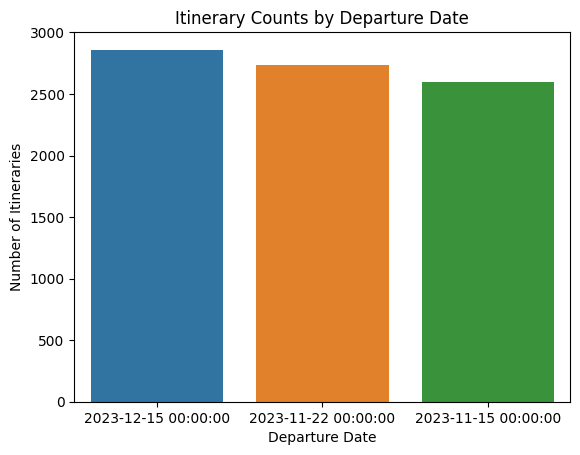

In [25]:
sns.countplot(x = 'Departure Date', data = df)
plt.title('Itinerary Counts by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Number of Itineraries')
plt.xticks(rotation = 45)
plt.show()

### **Price vs. Days Until Departure**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


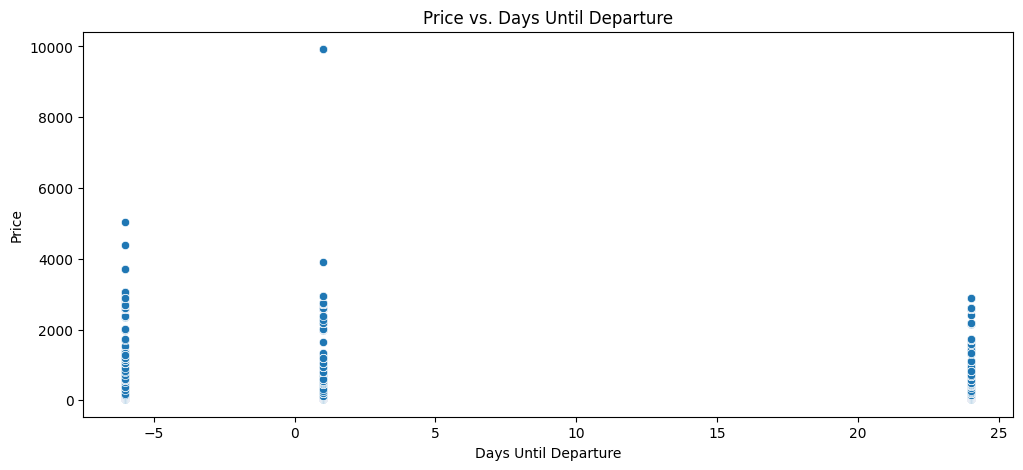

In [92]:
plt.figure(figsize = (12, 5))
sns.scatterplot(x = 'Days Until Departure', y = 'Price', data = df)
plt.title('Price vs. Days Until Departure')
plt.xlabel('Days Until Departure')
plt.ylabel('Price')
plt.show()

### **Average Price by Departure Date**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

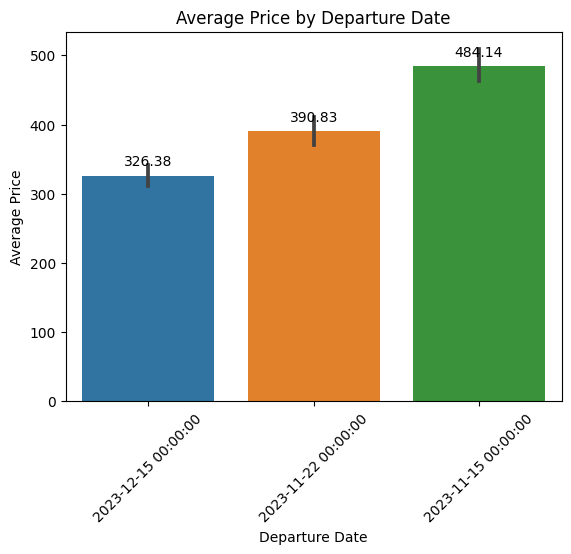

In [36]:
# Your existing code for plotting
barplot = sns.barplot(x = 'Departure Date', y = 'Price', data = df)
plt.title('Average Price by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Average Price')
plt.xticks(rotation = 45)

# Adding labels on top of the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 10),
                     textcoords = 'offset points')

plt.show()

### **Distribution of Categorical Features**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


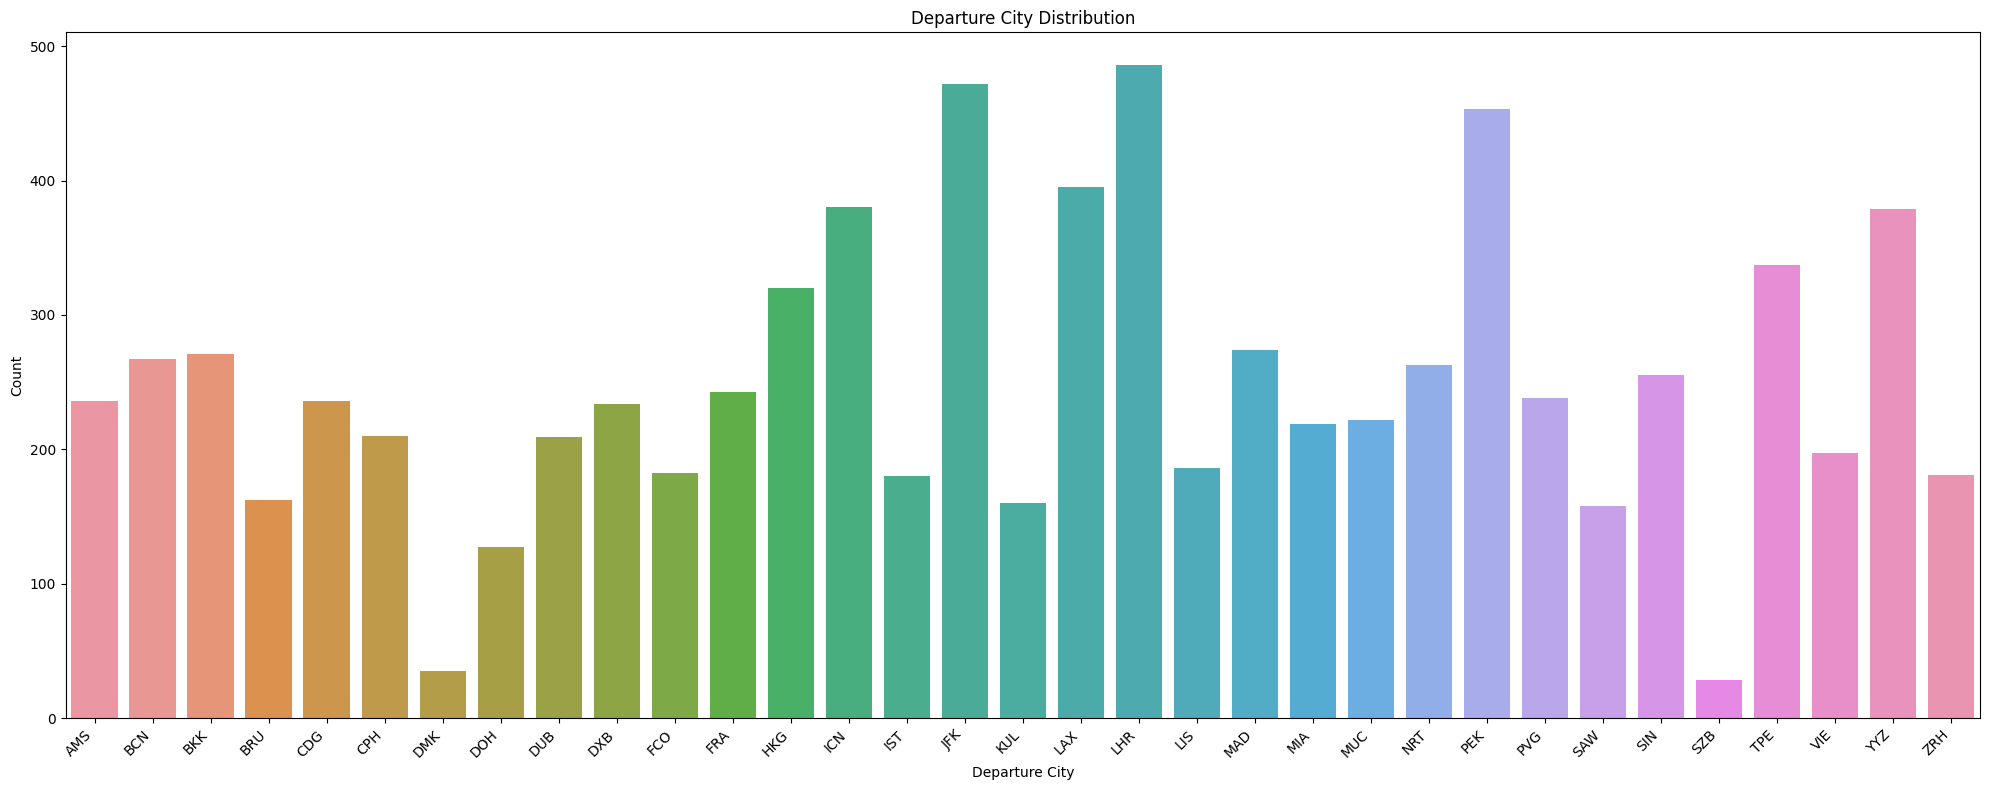

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


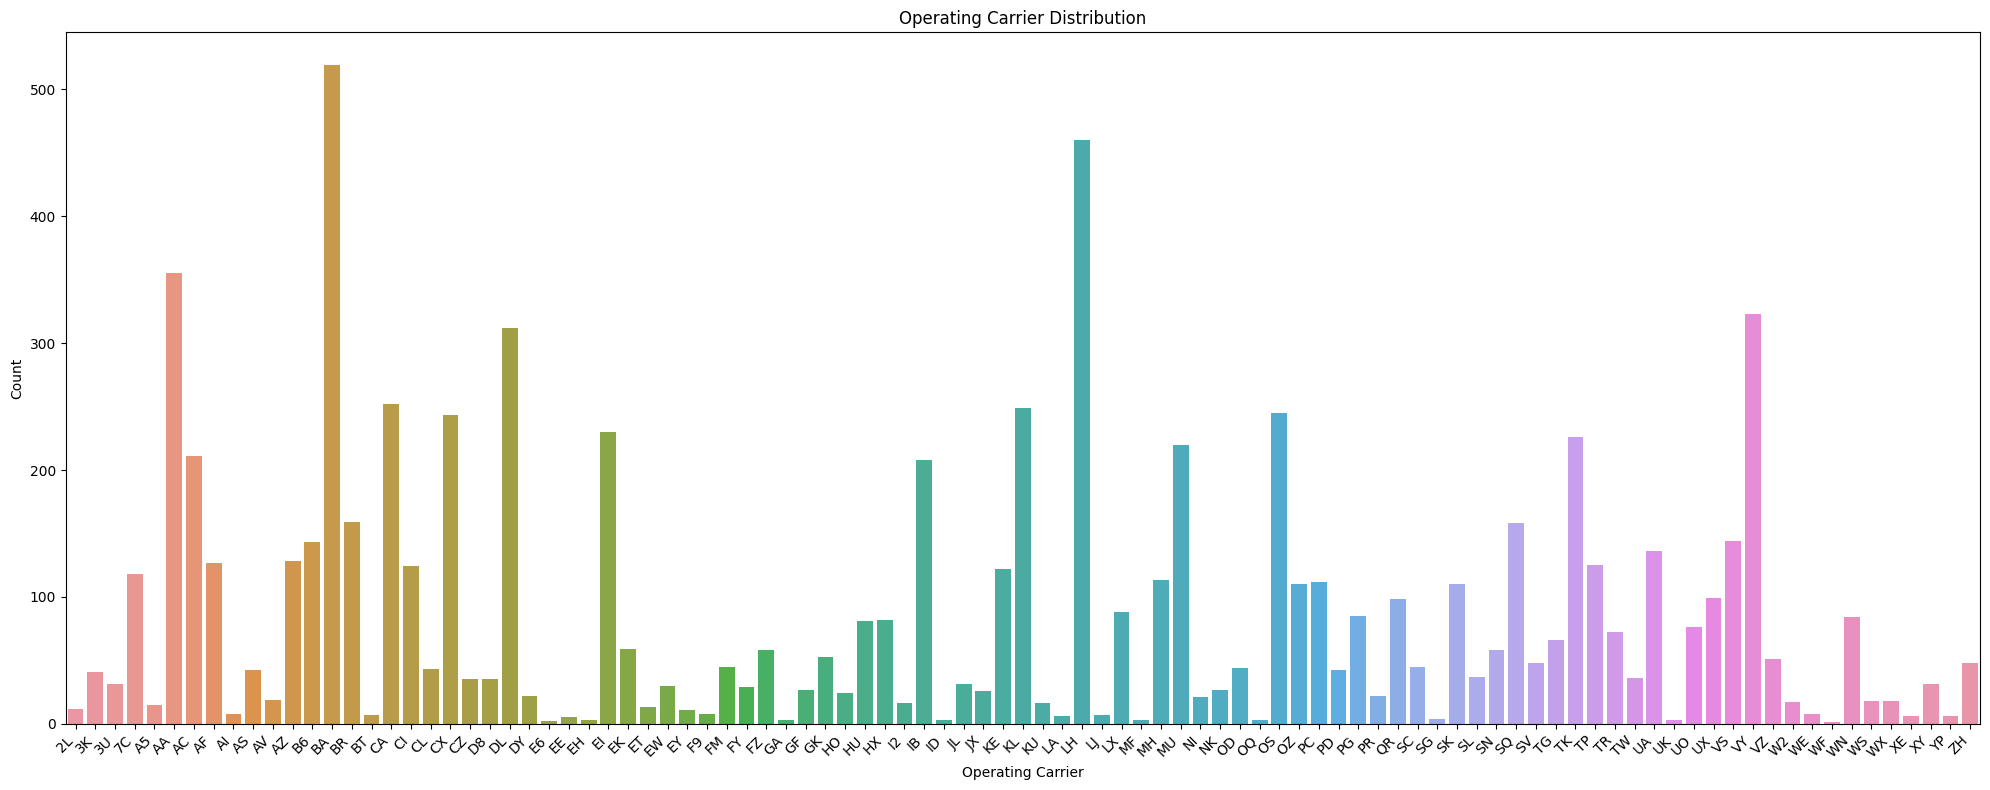

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


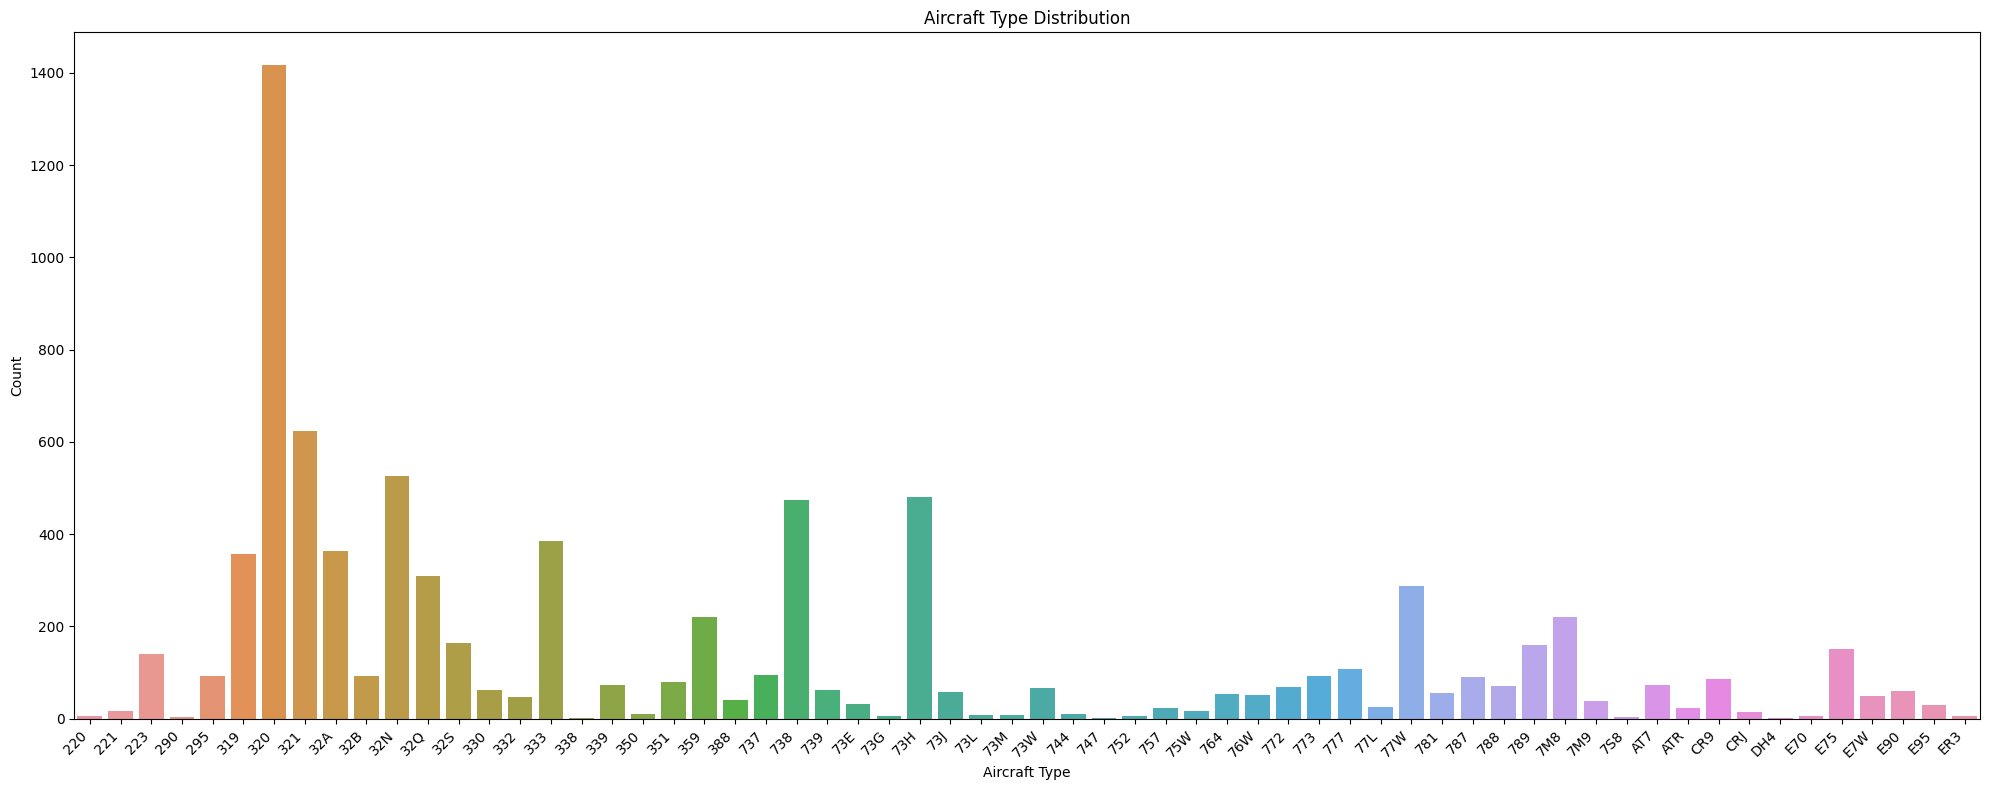

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


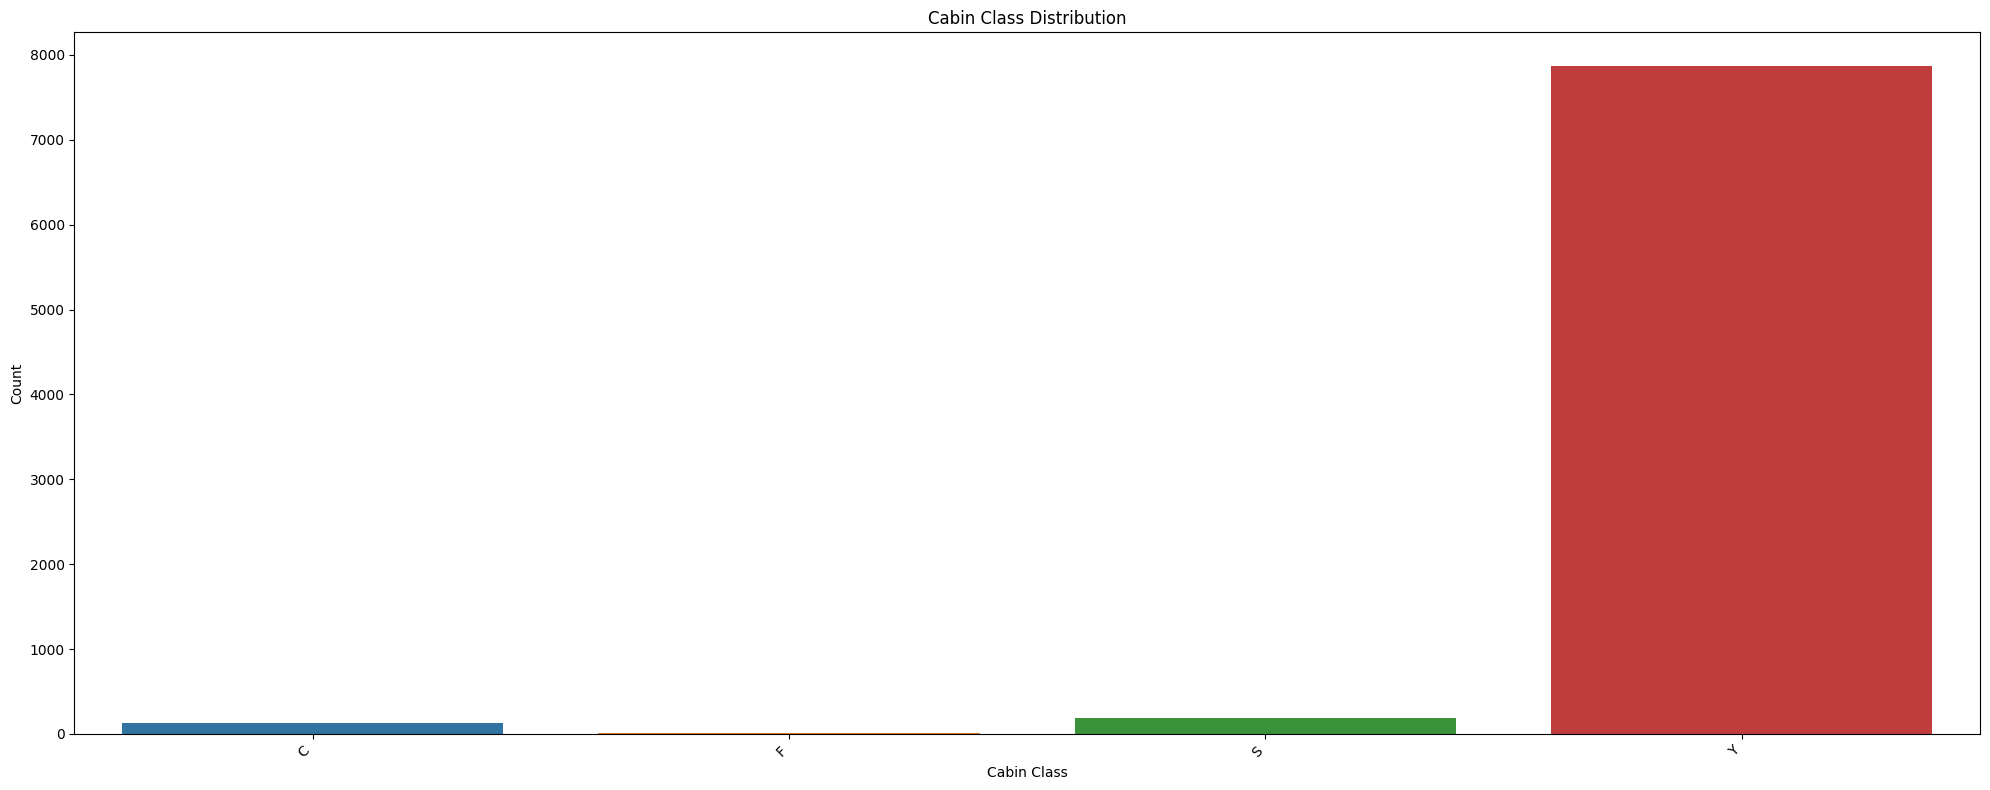

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


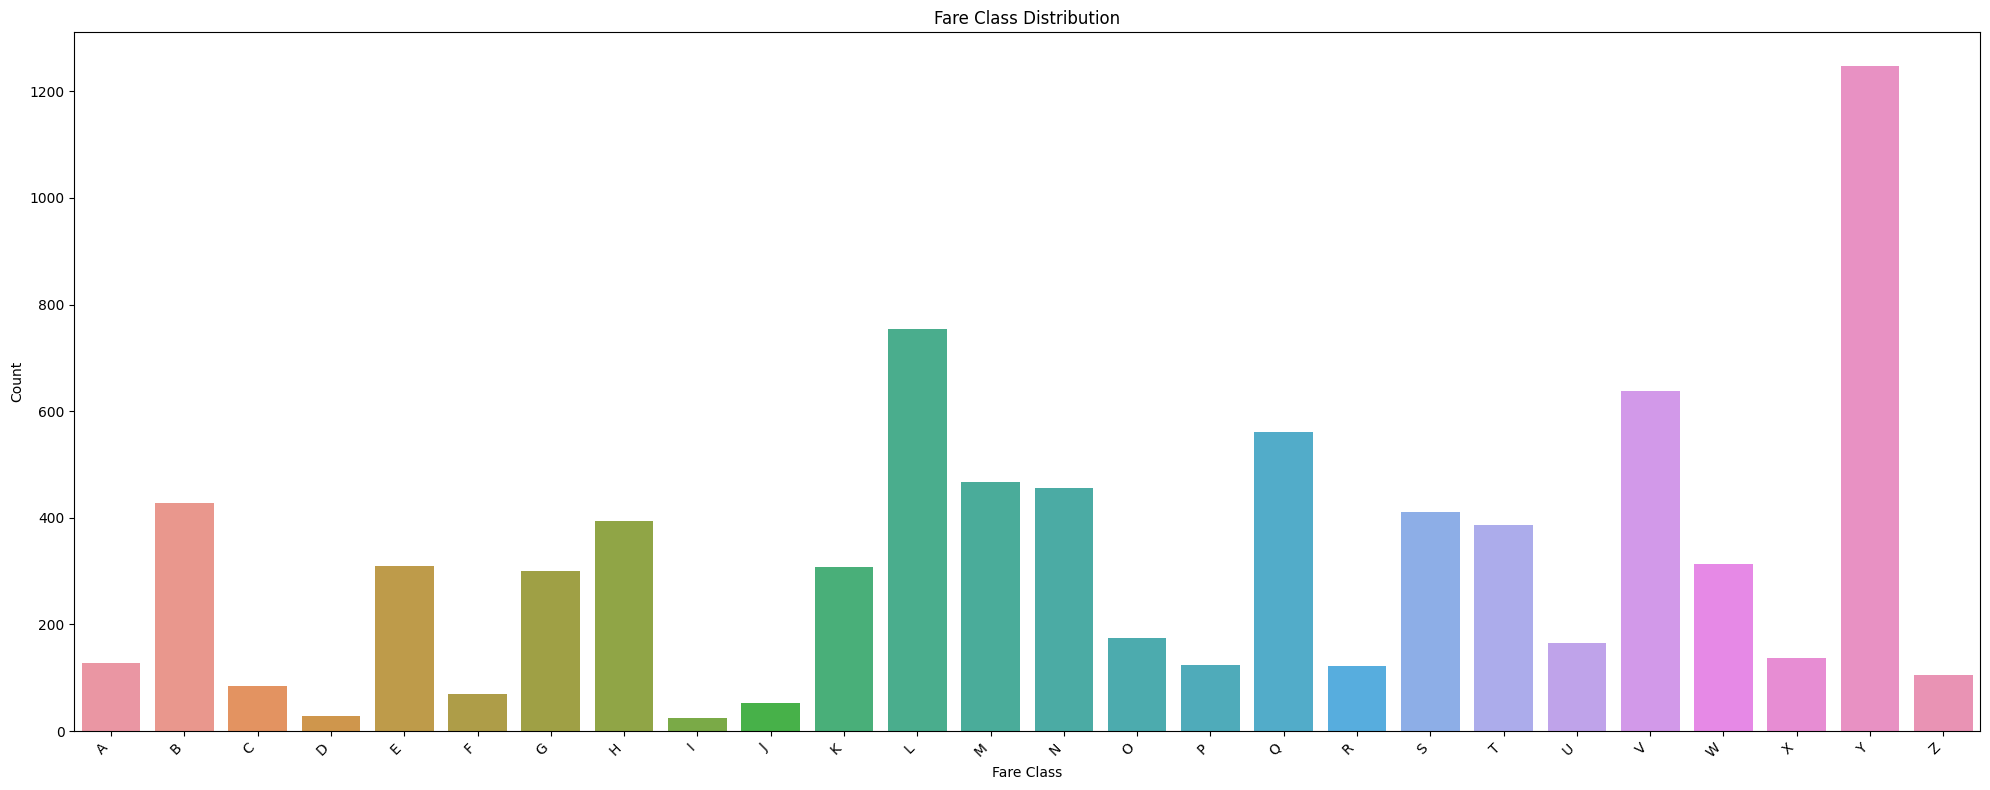

In [47]:
categorical_columns = ['Departure City', 'Operating Carrier', 'Aircraft Type', 'Cabin Class', 'Fare Class']

for column in categorical_columns:
    plt.figure(figsize = (20, 8))
    sns.countplot(x = column, data=df, order = sorted(df[column].unique()))
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation = 45, ha = 'right')
    plt.tight_layout()
    plt.show()

### **Distribution of Numerical Features**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


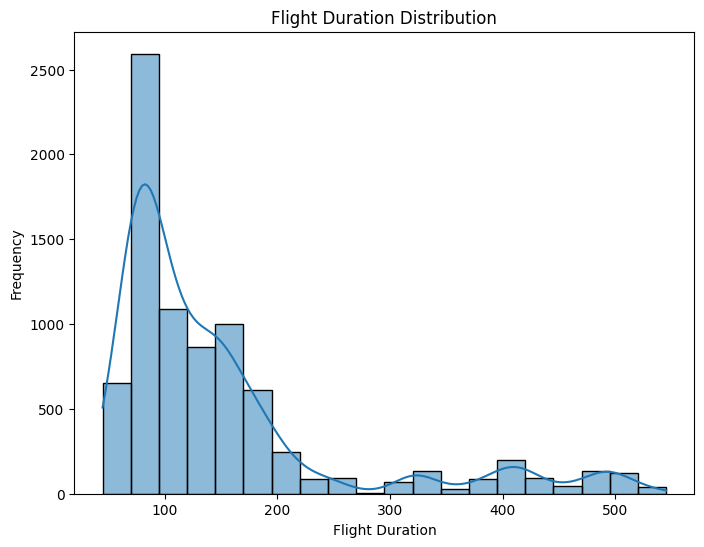

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


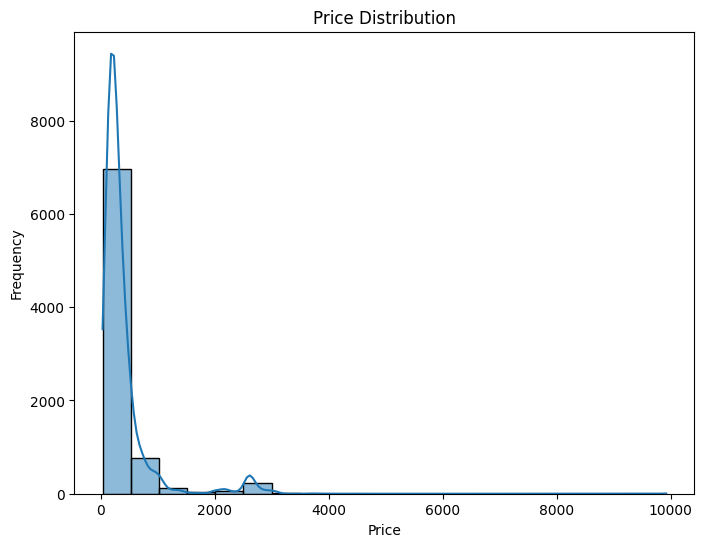

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


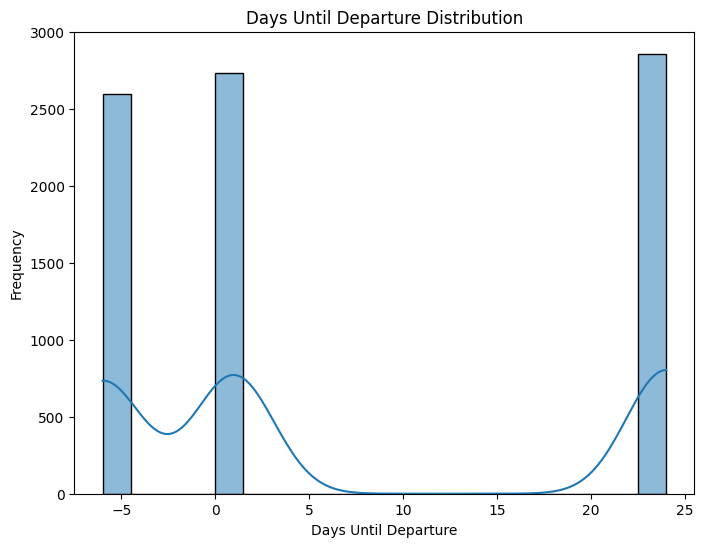

In [48]:
numerical_columns = ['Flight Duration', 'Price', 'Days Until Departure']

for column in numerical_columns:
    sns.histplot(df[column], kde = True, bins = 20)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

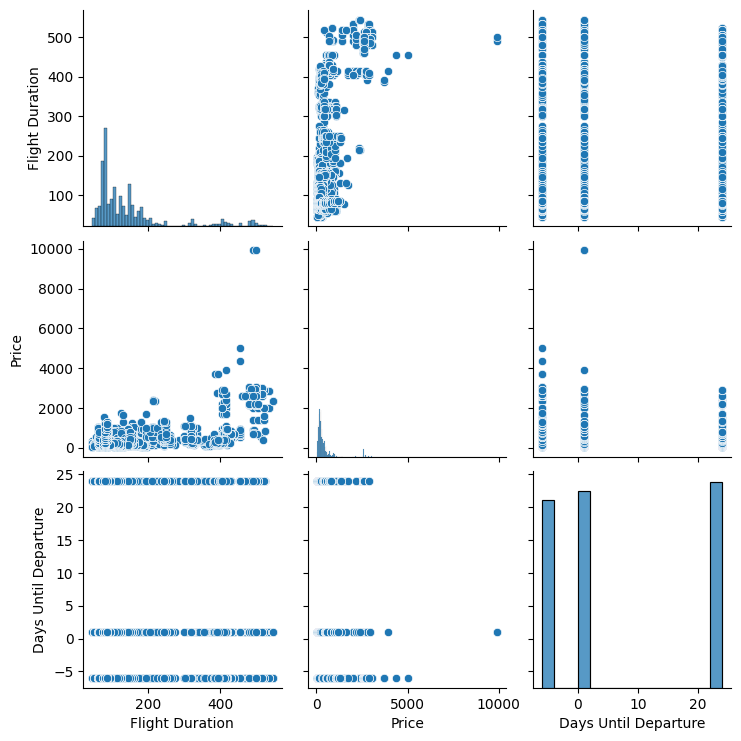

In [59]:
sns.pairplot(df[numerical_features])
plt.show()

### **Average Price by Departure City**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

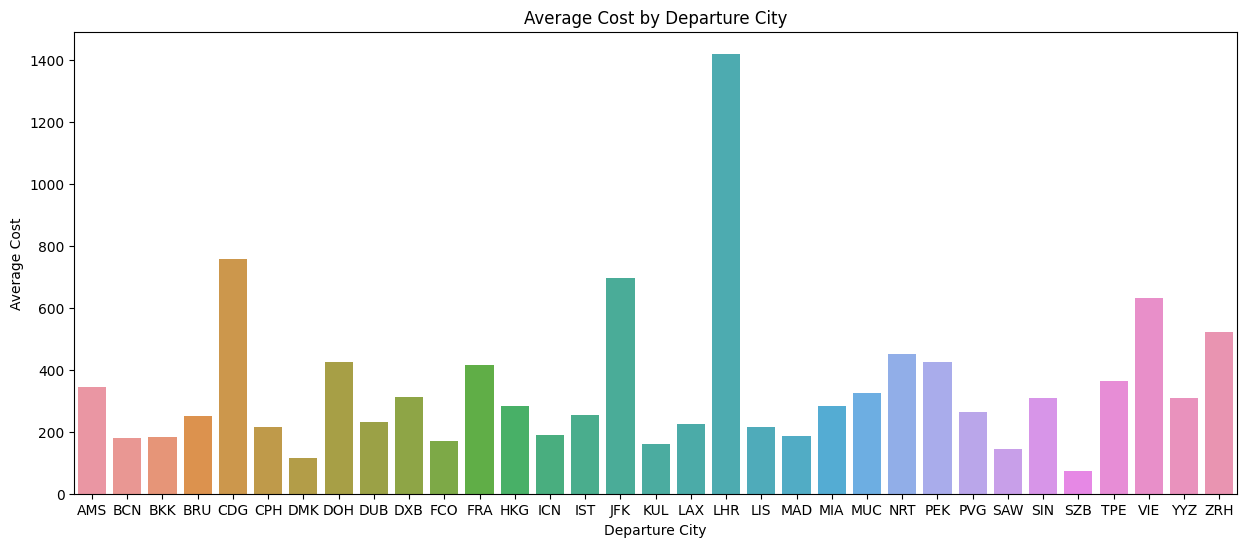

In [52]:
# Group by Departure City and calculate the mean for numerical columns
hub_stats = df.groupby('Departure City').agg({
    'Price': 'mean',
    'Flight Duration': 'mean',
}).reset_index()

# Average Cost by Departure City
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Departure City', y = 'Price', data = hub_stats)
plt.title('Average Price by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Price')
plt.show()

### **Average Flight Duration by Departure City**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

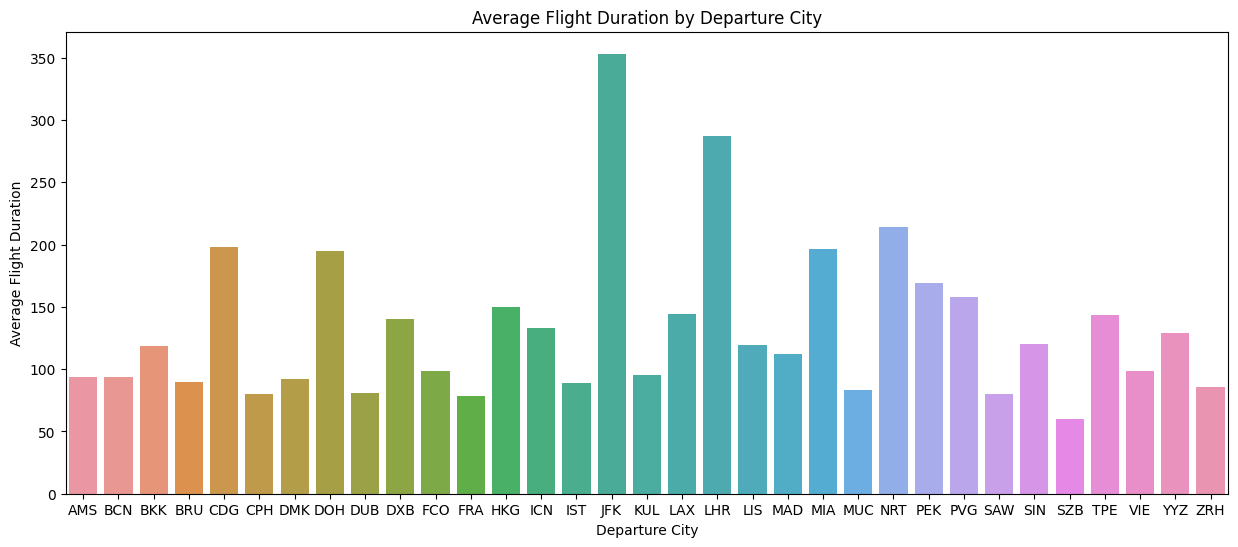

In [53]:
plt.figure(figsize = (15, 6))
sns.barplot(x = 'Departure City', y = 'Flight Duration', data = hub_stats)
plt.title('Average Flight Duration by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Flight Duration')
plt.show()

### **Average Price and Flight Duration by Departure City**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

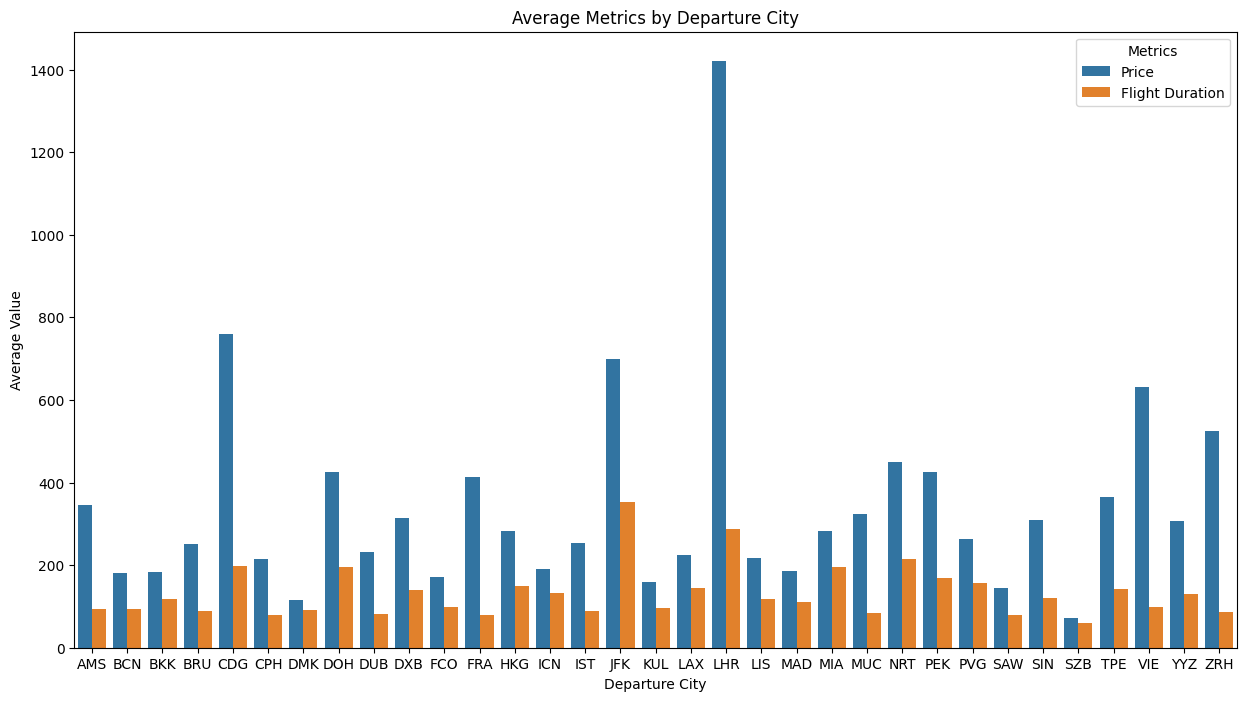

In [55]:
# Melt the dataframe to create a long-format dataframe for stacked bar chart
hub_stats_melted = hub_stats.melt(id_vars = 'Departure City', var_name = 'Metric', value_name = 'Value')

# Stacked bar chart for average cost, distance, and flight duration by departure city
plt.figure(figsize = (15, 8))
sns.barplot(x = 'Departure City', y = 'Value', hue = 'Metric', data = hub_stats_melted)
plt.title('Average Metrics by Departure City')
plt.xlabel('Departure City')
plt.ylabel('Average Value')
plt.legend(title = 'Metrics', loc = 'upper right')
plt.show()

### **Flight Duration by Operating Carrier**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) 

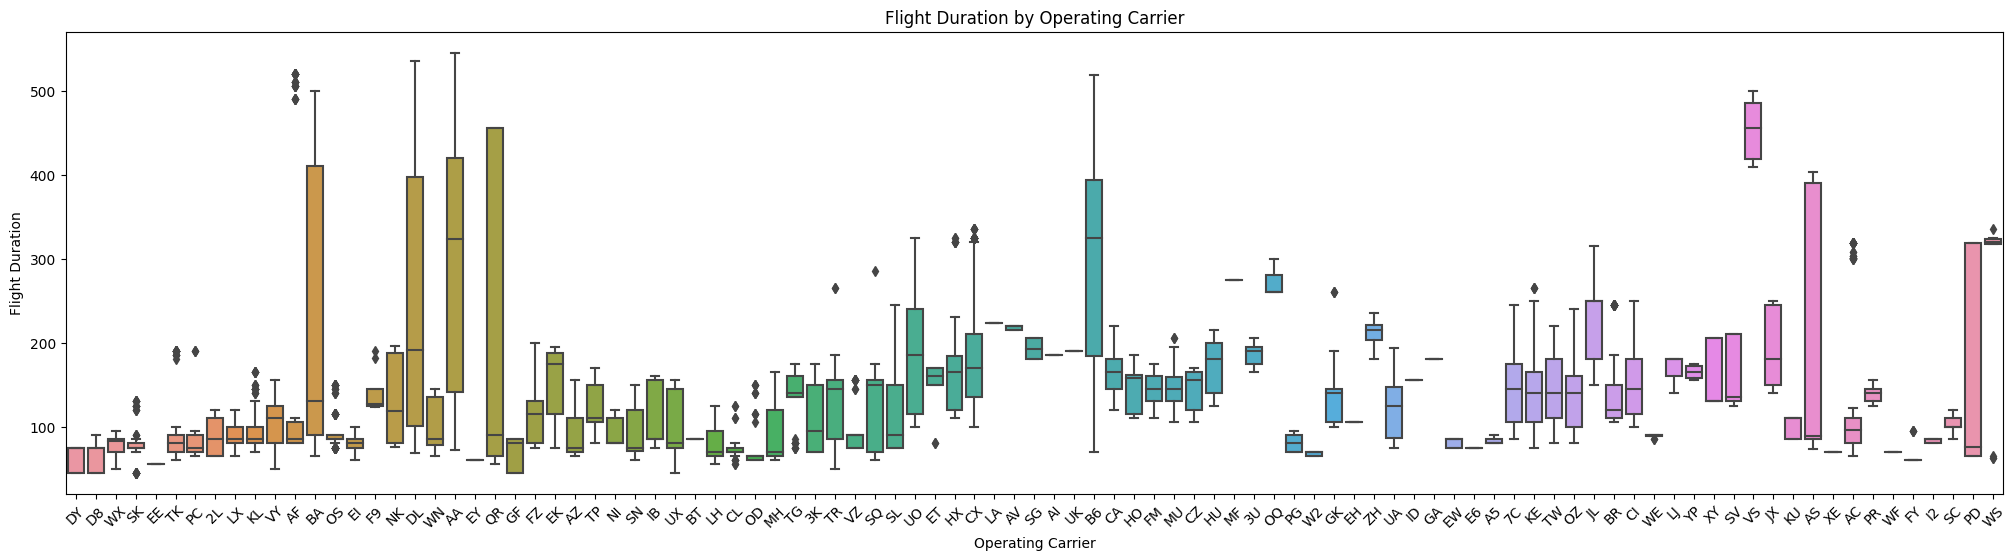

In [63]:
plt.figure(figsize = (25, 6))
sns.boxplot(x = 'Operating Carrier', y = 'Flight Duration', data = df)
plt.title('Flight Duration by Operating Carrier')
plt.xlabel('Operating Carrier')
plt.ylabel('Flight Duration')
plt.xticks(rotation = 45)
plt.show()

### **Flight Duration by Fare Class**

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


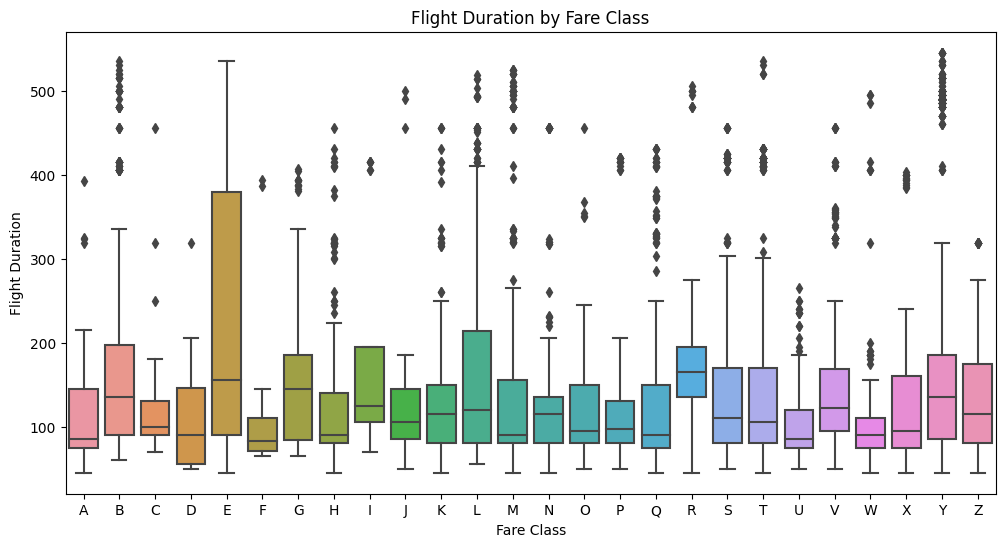

In [88]:
# Get the unique values of 'Fare Class' in alphabetical order
fare_class_order = sorted(df['Fare Class'].unique())

plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Fare Class', y = 'Flight Duration', data = df, order = fare_class_order)
plt.title('Flight Duration by Fare Class')
plt.xlabel('Fare Class')
plt.ylabel('Flight Duration')
plt.show()

### **Distribution of Fare Class by Departure Date**

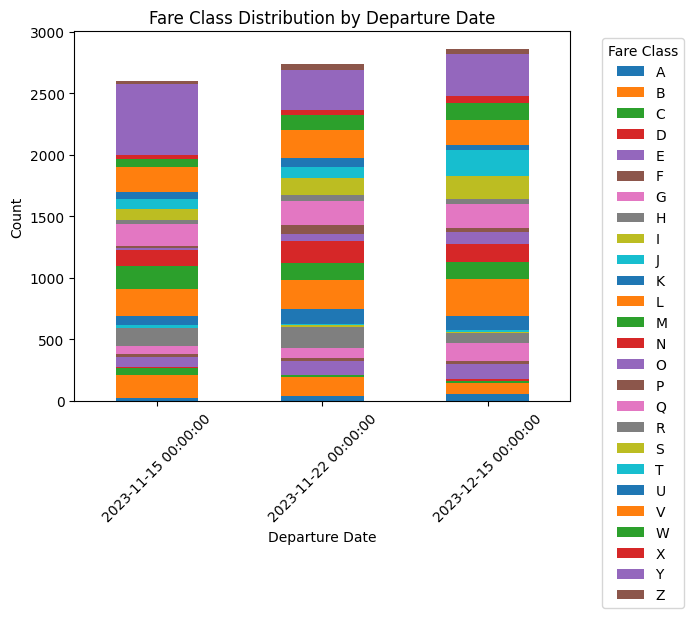

In [81]:
# Create a stacked dataframe
stacked_df = df.groupby(['Departure Date', 'Fare Class']).size().unstack()

# Plot stacked bar chart
stacked_df.plot(kind = 'bar', stacked = True)
plt.title('Fare Class Distribution by Departure Date')
plt.xlabel('Departure Date')
plt.ylabel('Count')
plt.xticks(rotation = 45)
plt.legend(title = 'Fare Class', bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.show()

### **Heatmap of Numerical Features**

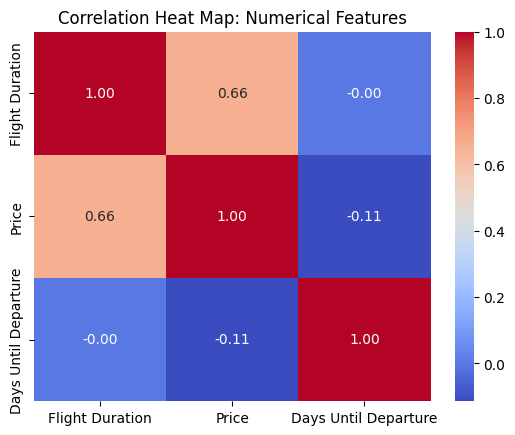

In [71]:
heatmap_data = df[numerical_columns]
sns.heatmap(heatmap_data.corr(), annot = True, cmap = 'coolwarm', fmt = ".2f")
plt.title('Correlation Heat Map: Numerical Features')
plt.show()